# 1. Rectification

The template below first asks the user to upload three files: an image (`IMAGE`) and two point files (`SOURCE_POINTS_FILE` and `TARGET_POINTS_FILE`).
The point files must be in the form
```
    X1 Y1
    X2 Y2
    X3 Y3
    X4 Y4
```
to define four 2D points.

The `rectify()` below maps the image region defined by the four corners from `SOURCE_POINTS_FILE` to the new region defined by `TARGET_POINTS_FILE`, using the functions
* `build_A()`,
* `compute_H()`,
* `bilinear_interp()`, and
* `warp_homography()`.

Complete these functions in the code cells below, and run Step1-1 to Step1-4. These steps simply do
1. Upload an image file as `IMAGE`, (use "laptop.jpg" for testing)
2. Upload an text file as `SOURCE_POINTS_FILE`, (use "laptop_screen.txt" for testing)
3. Upload an text file as `TARGET_POINTS_FILE`, and (use "laptop_rect.txt" for testing)
4. Run `rectify()` and show the output image.


In [268]:
import numpy as np

def build_A(pts1, pts2):
    """Constructs the intermediate matrix A used in the computation of an
    homography mapping pts1 to pts2."""
    # pts1: source, pts2: target
    n = pts1.shape[0]
    # left = np.zeros((2 * n, 6))
    # right = np.zeros((2 * n, 3))
    A = np.zeros((2 * n, 9))
    for i, (source, target) in enumerate(zip(pts1, pts2)):
        # source_extended := np.array([x, y, 1])
        source_extended = np.hstack((source, np.array([1])))
        A[2 * i, :3] = source_extended
        A[2 * i + 1, 3 : 6] = source_extended
        A[2 * i:2 * (i + 1), 6 : 9] = -target.reshape(2, -1) @ source_extended.reshape(1, -1)
    return A


In [269]:
def compute_H(pts1, pts2):
    """Computes an homography mapping one set of co-planar points (pts1) to another (pts2)."""

    # Construct the intermediate A matrix.
    A = build_A(pts1, pts2)

    # Compute the symmetric matrix AtA.
    AtA = A.T @ A

    # Compute the eigenvalues and eigenvectors of AtA.
    values, vectors,  = np.linalg.eig(AtA)

    # Return the eigenvector corresponding to the smallest eigenvalue, reshaped
    # as a 3x3 matrix.
    return  vectors[:, np.argmin(values)].reshape((3, 3))


In [270]:
def bilinear_interp(image, points: np.array):
    """Looks up the pixel values in an image at a given point using bilinear
    interpolation."""

    # Compute the four integer corner coordinates (top-left/right,
    # bottom-left/right) for interpolation, as well as the fractional part of
    # the coordinates.

    # Interpolate between the top two pixels.

    # Interpolate between the bottom two pixels.

    # Return the result of the final interpolation between top and bottom.

    # pointsは[x, y]．x, yはfloatなので，これを補間するtop-left/right, bottom-left/rightを求めて，それらでpointsの点の色を補間する
    # imageは (height x width x 3)

    # [x, y]
    top_left = np.floor(points).astype("int64")
    top_right = top_left + np.array([1, 0])
    bottom_left = top_left + np.array([0, 1])
    bottom_right = top_left + np.array([1, 1])

    if 0 <= bottom_right[0] < image.shape[1] and 0 <= bottom_right[1] < image.shape[0]:
        a, b = points - top_left  # 横・縦の比
        rgb = (
            a * b * image[top_left[1], top_left[0], :]
            + (1 - a) * b * image[top_right[1], top_right[0], :]
            + a * (1 - b) * image[bottom_left[1], bottom_left[0], :]
            + (1 - a) * (1 - b) * image[bottom_right[1], bottom_right[0], :]
        )
        return rgb
    return np.zeros(3)

In [350]:
def warp_homography(source, target_shape: np.ndarray, Hinv):
    """Warp the source image into the target coordinate frame using a provided
    inverse homography transformation."""
    # NOTE: This can be done much more efficiently (>10x faster) in Python
    # using a series of numpy array operations as opposed to a for loop.

    # Hints for fast version:
    # * Read about numpy broadcasting rules and reshaping operations.
    # * Look up numpy.mgrid / meshgrid for tips on how to quickly generate an
    #   array containing coordinates of all of the points in an image.
    # * You can modify your bilinear_interp() function to take an array of
    #   points instead of single points. Express the actions in this function
    #   using the aforementioned array operations.

    # Warp the source image to the corresponding coordinate system in the
    # output image by:
    #     * transforming points in the output image to the source image space (using the homography)
    #     * looking up pixel values in the source image at the transformed points (using bilinear interpolation)

    # 1. まずはoutput image空間をsource image空間に持っていく（meshグリッドの作成）
    # meshgridが表すのは，「output空間で表したグリッドは，直交座標で表すとこうなる」
    # 格子点がピクセル
    # meshgridで作るのはoutput空間中心で考えたときのgrid（つまり 0, 1, 2, 3, ...と等間隔で並んでいるグリッド）．これをHinvで変換する
    height, width, _ = target_shape
    XX, YY = np.meshgrid(np.arange(width), np.arange(height))
    transformed_XY = Hinv @ np.vstack((XX.reshape(1, -1), YY.reshape(1, -1), np.ones((1, height * width))))
    transformed_XY /= transformed_XY[2] # [[x], [y], [d]] を d で割る
    transformed_XX = transformed_XY[0].reshape(height, width) # output空間から見た直交座標のgrid（Grid点に対応するx座標）
    transformed_YY = transformed_XY[1].reshape(height, width) # output空間から見た直交座標のgrid（Grid点に対応するy座標）
    # output imageの[0, 0]成分は，source画像の[transformed_XX[0, 0], transformed_YY[0, 0]]成分と同じ
    output = np.zeros((*target_shape,))
    for i in range(height):
        for j in range(width):
            output[i, j] = bilinear_interp(source, np.array((transformed_XX[i, j], transformed_YY[i, j])))
    return output

In [351]:
def rectify(image, planar_points, target_points):
    # Compute the rectifying homography that warps the planar points to the
    # target rectangular region.
    H = compute_H(planar_points, target_points)

    # Apply the rectifying homography to the bounding box of the planar image
    # to find its corresponding bounding box in the rectified space.
    h, w, _ = image.shape
    # [x, y]
    corners = np.array([[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]]) # top_left, top_right, bottom_left, bottom_right
    rectified_space = H @ np.vstack((corners.T, np.ones((1, corners.shape[0]))))
    rectified_space /= rectified_space[2] # [[x], [y], [d]] を d で割る
    r_left, r_right, r_top, r_bottom = map(int, [np.min(rectified_space[0]), np.max(rectified_space[0]), np.min(rectified_space[1]), np.max(rectified_space[1])])
    # offset_w, offset_h = rectified_space.T[0, :2].astype("int64") # r_top_left
    target_shape = np.array([r_bottom - r_top, r_right - r_left, 3])

    # Offset the rectified bounding box such that its minimum point (the top
    # left corner) lies at the origin of the rectified space.

    # Compute the inverse homography to warp between the offset, rectified
    # bounding box and the bounding box of the input image.
    Hinv = np.linalg.inv(H) @ np.array([[1, 0, r_left], [0, 1, r_top], [0, 0, 1]])
    
    # Perform inverse warping and return the result.
    return warp_homography(image, target_shape, Hinv)


In [273]:
# colaboratory-specific helper functions

import cv2
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import files

# def upload_sub(msg):
#     print(msg)
#     f = files.upload()
#     if bool(f) is False:
#         return None
#     fname = list(f.keys())[0]
#     return fname

# def upload(msg):
#     f = None
#     while f is None:
#         f = upload_sub(msg)
#     return f

In [378]:
from pathlib import Path
datapath = Path("test_data")

## Step 1-1: Upload `IMAGE`

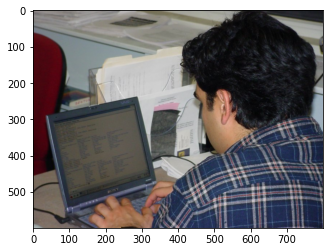

In [379]:
# image = cv2.imread(upload('IMAGE:'), cv2.IMREAD_COLOR) # Use laptop.jpg for testing
image = cv2.imread(str(datapath / "laptop.jpg"), cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Step 1-2: Upload `SOURCE_POINTS_FILE`

In [380]:
# pts1 = np.loadtxt(upload('SOURCE_POINTS_FILE:')) # Use laptop_screen.txt for testing
pts1 = np.loadtxt(str(datapath / "laptop_screen.txt"))
print(pts1)

[[ 56. 308.]
 [280. 259.]
 [323. 455.]
 [102. 521.]]


## Step 1-3:  TARGET_POINTS_FILE

In [381]:
# pts2 = np.loadtxt(upload('TARGET_POINTS_FILE:')) # Use laptop_rect.txt for testing
pts2 = np.loadtxt(str(datapath / "laptop_rect.txt"))
print(pts2)

[[  0.   0.]
 [160.   0.]
 [160. 120.]
 [  0. 120.]]


## Step 1-4: Rectify

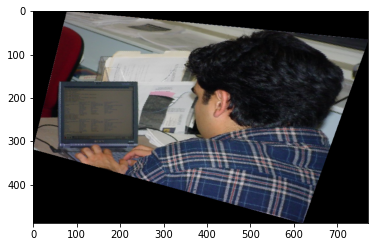

In [382]:
rectified = rectify(image, pts1, pts2).astype(np.uint8)

plt.imshow(cv2.cvtColor(rectified, cv2.COLOR_BGR2RGB))
plt.show()

# Just in case you want to download the output

# cv2.imwrite("rectified.png", rectified)plt.imshow(cv2.cvtColor(rectified, cv2.COLOR_BGR2RGB))
plt.show()

# 2. Composition

The function `composite()` below superimposes a region of a `source` image on top of a region of a `target` image. The source and the target regions are specified by corresponding points as done for `rectify()` above.

The function also takes a `mask` image which defines the transparency of `source`. This works as a stencil buffer if `mask` is a binary image, or as an alpha blending mask if grayscale.

In [363]:
def blend_with_mask(source, target, mask):
    """Blends the source image with the target image according to the mask.
    Pixels with value "1" are source pixels, "0" are target pixels, and
    intermediate values are interpolated linearly between the two."""
    # targetがsourceの次元で与えられている場合
    return source * mask + target * (1 - mask)

In [367]:
def composite(source, target, source_pts, target_pts, mask):
    """Composites a masked planar region of the source image onto a
    corresponding planar region of the target image via homography warping."""

    # Compute the homography to warp points from the target to the source coordinate frame.
    H = compute_H(target_pts, source_pts)

    # Warp the images using the homography.
    source_shape = source_pts[2].astype("int64") + np.array([1, 1])
    source_shape = np.array([source_shape[1], source_shape[0], 3])
    warped_target = warp_homography(target, source_shape, Hinv=np.linalg.inv(H))
    blended = blend_with_mask(source, warped_target, mask)
    warped_blended = warp_homography(blended, target.shape, Hinv=H)
    # warped_blendedのうち，0の部分を1に変換し,0より大きい部分を0に変換する
    mask4blend = 1 - (warped_blended > 0)
    return target * mask4blend + warped_blended
    # Blend the warped images.
    


## Step 2-1: Upload `SOURCE` image

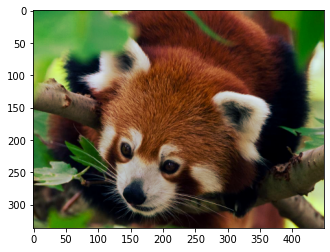

In [383]:
# source = cv2.imread(upload('SOURCE:'), cv2.IMREAD_COLOR) # Use panda.png for testing
source = cv2.imread(str(datapath / "panda.png"), cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(source, cv2.COLOR_BGR2RGB))
plt.show()

## Step 2-2: Upload `TARGET` image

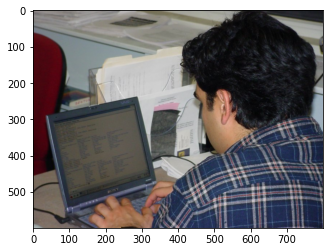

In [385]:
# target = cv2.imread(upload('TARGET:'), cv2.IMREAD_COLOR) # Use laptop.jpg for testing
target = cv2.imread(str(datapath / "laptop.jpg"), cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB))

## Step 2-3: Upload `SOURCE_POINTS` file

In [386]:
# source_pts = np.loadtxt(upload('SOURCE_POINTS_FILE:')) # Use panda_point.txt for testing
source_pts = np.loadtxt(str(datapath / "panda_points.txt"))
print(source_pts)

[[  0.   0.]
 [448.   0.]
 [448. 335.]
 [  0. 335.]]


## Step 2-4: Upload `TARGET_POINTS` file

In [387]:
# target_pts = np.loadtxt(upload('TARGET_POINTS_FILE:')) # Use laptop_screen.txt for testing
target_pts = np.loadtxt(str(datapath / "laptop_screen.txt"))
print(target_pts)

[[ 56. 308.]
 [280. 259.]
 [323. 455.]
 [102. 521.]]


## Step 2-5: Upload `MASK` image

(336, 449)
(336, 449, 1)


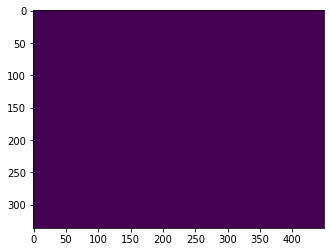

In [388]:
# mask = cv2.imread(upload('MASK:'), cv2.IMREAD_GRAYSCALE) # Use panda_mask.png for testing
mask = cv2.imread(str(datapath / "panda_mask.png"), cv2.IMREAD_GRAYSCALE)
plt.imshow(mask)
print(mask.shape)

mask = mask[:, :, np.newaxis]
print(mask.shape)

## Step 2-6: Composite

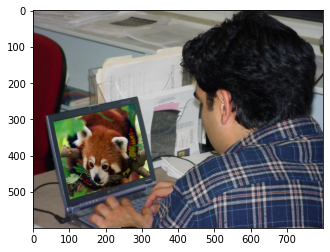

In [368]:
# composite(source, target, source_pts, target_pts, mask/255.0)
composited = composite(source, target, source_pts, target_pts, mask/255.0).astype(np.uint8)
plt.imshow(cv2.cvtColor(composited, cv2.COLOR_BGR2RGB))